# Importing the Modules used in the Project

In [ ]:
#Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import os
import PIL as image
import matplotlib.pyplot as plt

#Tensorflow Libraries
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, MaxPooling2D, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers

#Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from skimage.transform import resize

#NN Transfer
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input



# Importing data from kaggle and defining X_train and y_train

80% of the images our in training set and 20% are in validation set

In [ ]:
#Install Kaggle
!pip install -q kaggle

In [ ]:
#uploading the json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kunal252","key":"659fd67499cc6eb5ca8717a824468738"}'}

In [ ]:
# #Make directory named kaggle
!mkdir ~/.kaggle

# #Copy kaggle.json file there
! cp kaggle.json ~/.kaggle/

#Change the permission of the file
! chmod 600 ~/.kaggle/kaggle.json

#Download the dataset zip in this location 
DATA_DIR = '../data' 

In [ ]:
#Downloading the dataset from kaggle
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 84% 65.0M/77.3M [00:07<00:01, 7.53MB/s]
100% 77.3M/77.3M [00:07<00:00, 11.4MB/s]
  0% 0.00/7.01k [00:00<?, ?B/s]
100% 7.01k/7.01k [00:00<00:00, 7.25MB/s]
 47% 9.00M/19.3M [00:01<00:01, 6.42MB/s]
100% 19.3M/19.3M [00:01<00:00, 15.3MB/s]
 95% 87.0M/92.0M [00:03<00:00, 19.7MB/s]
100% 92.0M/92.0M [00:03<00:00, 26.9MB/s]
 98% 95.0M/96.6M [00:07<00:00, 12.7MB/s]
100% 96.6M/96.6M [00:07<00:00, 13.8MB/s]


In [ ]:
#Unzipping the downloaded files
!unzip -qq icml_face_data.csv.zip
!unzip -qq train.csv.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Path of the dataset
data_path = '/content/'
train_pth = os.path.join(data_path,'train.csv')
AllData_pth = os.path.join(data_path,'icml_face_data.csv')

In [ ]:
train_csv = pd.read_csv(train_pth)
train_csv.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
#Defining the test Data set using icml_face_data.csv
data = pd.read_csv(AllData_pth)
test_csv = data.drop(data.index[:28709])
test_csv.head()

,emotion,Usage,pixels
28709,0,PublicTest,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
28710,1,PublicTest,156 184 198 202 204 207 210 212 213 214 215 21...
28711,4,PublicTest,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
28712,6,PublicTest,205 203 236 157 83 158 120 116 94 86 155 180 2...
28713,3,PublicTest,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


In [ ]:
#removing any existing directories that are not required
!rm example_submission.csv
!rm fer2013.tar.gz
!rm icml_face_data.csv.zip
!rm train.csv.zip
!rm test.csv.zip

In [ ]:
#Defining y_test
y_test = np.asarray(test_csv['emotion'])
y_test.reshape(7178,1)
y_test = np.expand_dims(y_test,1)
y_test = to_categorical(y_test)

#Defining X_test
X_test = []
pixel_arr = np.asarray(test_csv[' pixels'])
pixel_arr.reshape(test_csv.shape[0],1)
for a in pixel_arr:
    X_test.append(np.asarray(a.split(" "),dtype=np.float32).reshape(48,48))

X_test = np.asarray(X_test)
X_test = np.expand_dims(X_test,3)

print("Shape of X_test: {}, y_test: {}".format(X_test.shape,y_test.shape))

Shape of X_test: (7178, 48, 48, 1), y_test: (7178, 7)


##Creating a dictionary for each emotion category

In [ ]:
emotiondict = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

##One Hot Encoding and Definition of Predictor variable

In [ ]:
#Defining y and X

#Define response variable and onehotencode it
y = np.asarray(train_csv['emotion'])
y.reshape(28709,1)
y = to_categorical(y)
print("Predictor is One Hot Encoded Shape = {}".format(y.shape))

#Define predictor variable
#String from the CSV file is split into a 2304 element float32 array
#its then reshaped to into a 48,48 image and then normalized by dividing by 255
X = []
pixel_arr = np.asarray(train_csv['pixels'])
pixel_arr.reshape(28709,1)
for a in pixel_arr:
    X.append(np.asarray(a.split(" "),dtype=np.float32).reshape(48,48))
X = np.asarray(X)
print("Shape of Predictor variable: {}".format(X.shape))


table = pd.pivot_table(train_csv, index=['emotion'], aggfunc='size')
print("The number of images under each Category of expression")
print(table)
print(emotiondict)


Predictor is One Hot Encoded Shape = (28709, 7)
Shape of Predictor variable: (28709, 48, 48)
The number of images under each Category of expression
emotion
0    3995
1     436
2    4097
3    7215
4    4830
5    3171
6    4965
dtype: int64
{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


##Displaying 3 emotions with their one-hot encoded emotion category

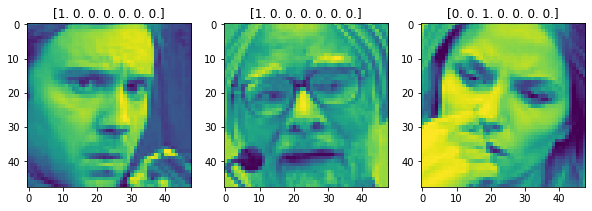

In [ ]:
#Plotting three images of the X Dataset with their label
fig, axs = plt.subplots(1,3, figsize=(13,13))
axs[0].imshow(X[0])
axs[0].title.set_text(str(y[0]))
axs[1].imshow(X[1])
axs[1].title.set_text(str(y[1]))
axs[2].imshow(X[2])
axs[2].title.set_text(str(y[2]))

# Creating Image Data Generators

---



In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.19967)
#It needs to be expanded to include the number of channels
X_train = np.expand_dims(X_train,3)
X_val = np.expand_dims(X_val,3)

In [ ]:
print("Shapes of X_train: {}, y_train: {}, X_val: {}, y_val: {}".format(X_train.shape,y_train.shape,X_val.shape,y_val.shape))

Shapes of X_train: (22976, 48, 48, 1), y_train: (22976, 7), X_val: (5733, 48, 48, 1), y_val: (5733, 7)


In [ ]:
#defining Data generators
datagen_train = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   horizontal_flip=True)
datagen_val = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   horizontal_flip=True)
#applying the data augments
datagen_train.fit(X_train)
datagen_val.fit(X_val)


# Creating our Custom Model

In [ ]:
model = Sequential()

#Conv layer 1
model.add(Conv2D(64,(3,3),padding='same',activation='relu',input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.2))

#Conv layer 2
model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Conv layer 4
model.add(Conv2D(256,(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Conv layer 3
model.add(Conv2D(512,(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

#Conv layer 4
model.add(Conv2D(512,(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())

#Fully connected Layers
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(7,activation='softmax'))

In [ ]:
#Compile model
model.compile(loss='categorical_crossentropy',optimizer=optimizers.SGD(learning_rate=0.001,momentum=0.95),metrics=['accuracy'])
#model.summary()

In [ ]:
#fitting the model

fit = True
history=None
if fit == True:
	#model.fit_generator(x_train, y_train, epochs=epochs) #train for all trainset
  history = model.fit(datagen_train.flow(X_train,y_train,batch_size=32), epochs=100, validation_data=datagen_val.flow(X_val,y_val),verbose=2)
else:
	model.load_weights('model.h5') #load weights
model.save('model.h5')

Epoch 1/100
718/718 - 15s - loss: 2.4039 - accuracy: 0.1753 - val_loss: 1.9200 - val_accuracy: 0.2468
Epoch 2/100
718/718 - 14s - loss: 2.1220 - accuracy: 0.1979 - val_loss: 1.8264 - val_accuracy: 0.2643
Epoch 3/100
718/718 - 14s - loss: 2.0014 - accuracy: 0.2186 - val_loss: 1.8025 - val_accuracy: 0.2723
Epoch 4/100
718/718 - 14s - loss: 1.9363 - accuracy: 0.2259 - val_loss: 1.7696 - val_accuracy: 0.2812
Epoch 5/100
718/718 - 14s - loss: 1.8939 - accuracy: 0.2401 - val_loss: 1.7668 - val_accuracy: 0.2857
Epoch 6/100
718/718 - 14s - loss: 1.8657 - accuracy: 0.2471 - val_loss: 1.7498 - val_accuracy: 0.2892
Epoch 7/100
718/718 - 14s - loss: 1.8321 - accuracy: 0.2564 - val_loss: 1.7349 - val_accuracy: 0.2958
Epoch 8/100
718/718 - 14s - loss: 1.8136 - accuracy: 0.2653 - val_loss: 1.7206 - val_accuracy: 0.2993
Epoch 9/100
718/718 - 14s - loss: 1.7869 - accuracy: 0.2735 - val_loss: 1.7051 - val_accuracy: 0.3087
Epoch 10/100
718/718 - 14s - loss: 1.7638 - accuracy: 0.2867 - val_loss: 1.7007 - 

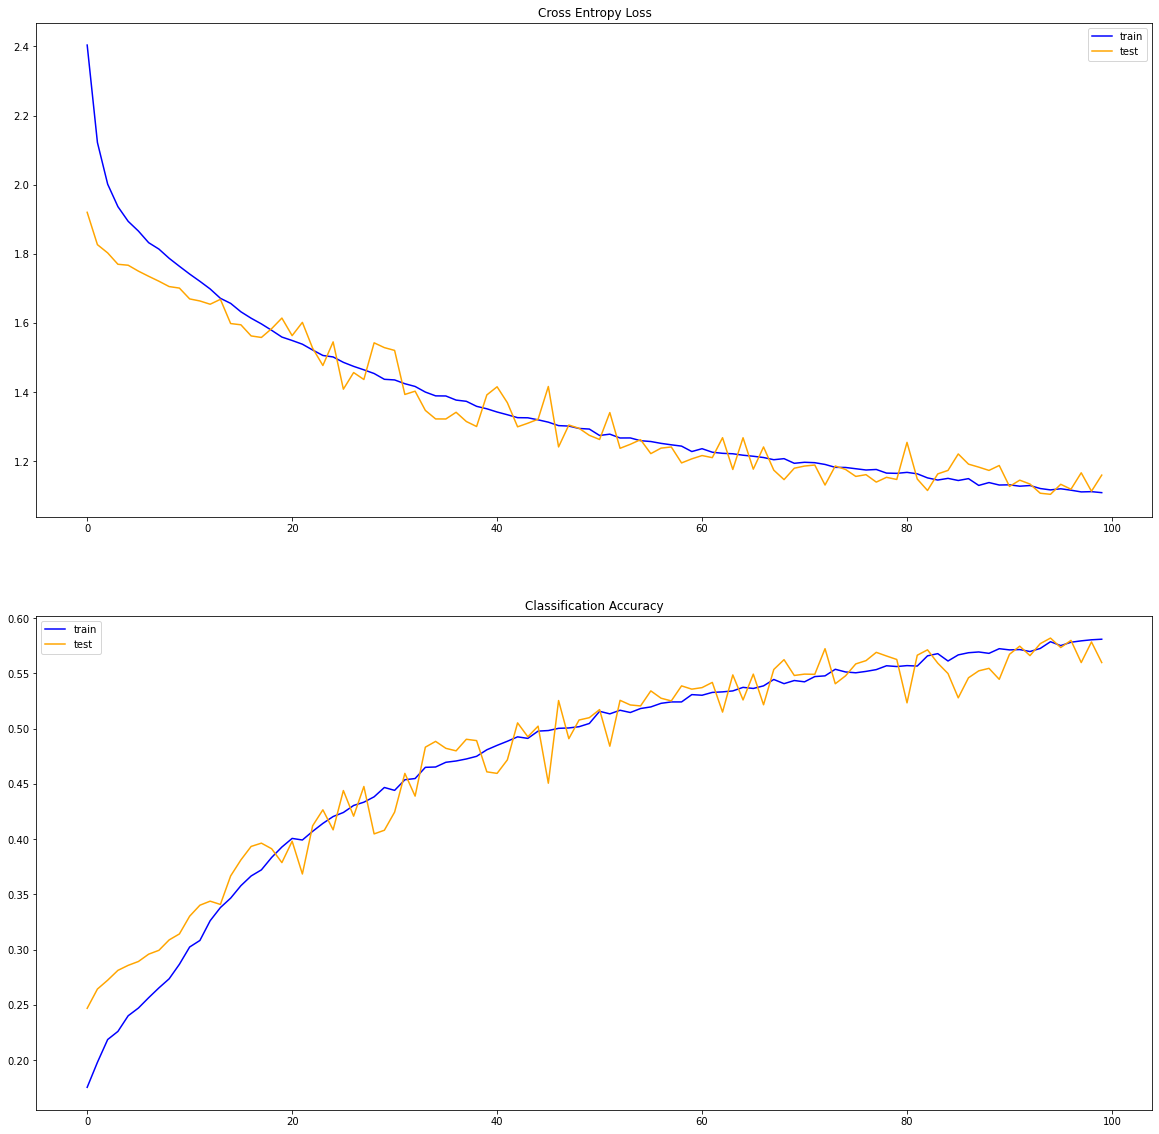

In [ ]:
#Don't change this I like my graphs #-->Graphs are too large to scroll

fig, axs = plt.subplots(2,1,figsize=(20,20))
axs[0].title.set_text('Cross Entropy Loss')
axs[0].plot(history.history['loss'], color='blue', label='train')
axs[0].plot(history.history['val_loss'], color='orange', label='test')
axs[0].legend()
axs[1].title.set_text('Classification Accuracy')
axs[1].plot(history.history['accuracy'], color='blue', label='train')
axs[1].plot(history.history['val_accuracy'], color='orange', label='test')
axs[1].legend()

In [ ]:
#Evaluate the model
acc = model.evaluate(X_test,y_test,verbose=0)
print("Evaluate on test data")
print("Test Loss: {}, Test Acc: {}".format(acc[0],acc[1]))

Evaluate on test data
Test Loss: 229.3628387451172, Test Acc: 0.17177486419677734


In [ ]:
#Testing the model
y_pred = model.predict(X_test)
print("The MSE of Model: {}".format(mean_squared_error(y_test,y_pred)))

The MSE of Model: 0.23482181131839752


# Transfer Learning using VGG16 Network

###Why VGG16?

VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. The model achieved a 92.7% top-5 test accuracy on ImageNet (a dataset of over 14 million images with 1000 classes). It was one of the most iconic models submitted at ILSVRC-2014. An improvement over AlexNet, VGG16 replaces large kernel-sized filters (11 and 5 in the first and second convolutional layer, respectively) with multiple 3×3 kernel-sized filters one after another. The original VGG16 was trained for weeks and was using NVIDIA Titan Black GPU’s. Here, we attempt to use transfer learning and import a pretrained model, replacing only the last few layers.

###The VGG16 Architecture

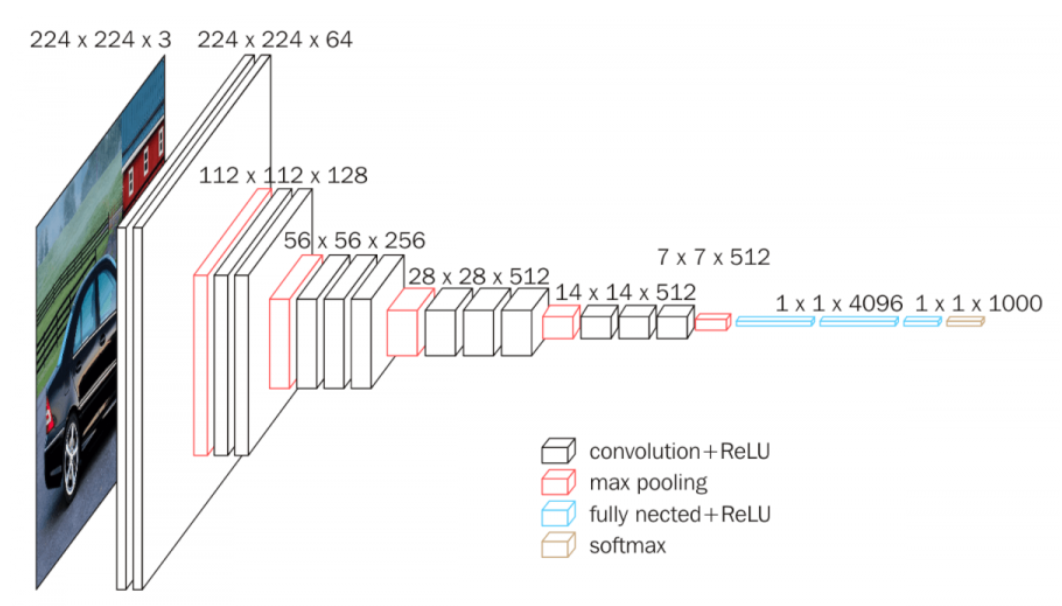

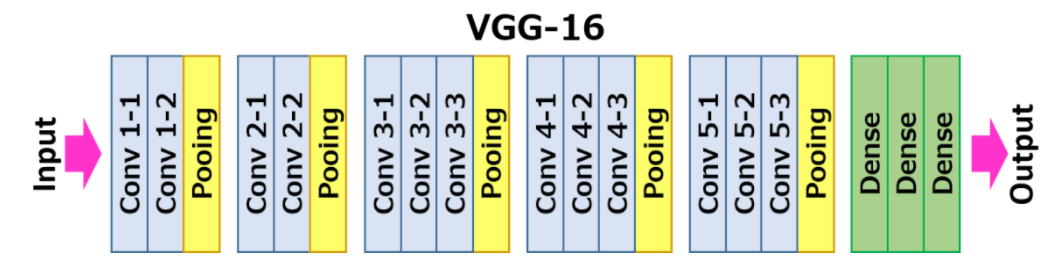

###A Description of the Architecture

<ul>
<li> The input to conv1 layer is a fixed size 224 x 224 RGB image. The image is passed through a stack of convolutional (conv.) layers with a very small receptive field: 3×3. 
<li> In one of the configurations, it also utilizes 1×1 convolution filters, which can be seen as a linear transformation of the input channels (followed by non-linearity). 
<li> The convolution stride is fixed to 1 pixel; the spatial padding of conv. layer input is such that the spatial resolution is preserved after convolution, i.e. the padding is 1-pixel for 3×3 conv. layers. 
<li> Spatial pooling is carried out by five max-pooling layers, which follow some of the conv.  layers (not all the conv. layers are followed by max-pooling). Max-pooling is performed over a 2×2 pixel window, with stride 2.

Three Fully-Connected (FC) layers follow a stack of convolutional layers (which has a different depth in different architectures): the first two have 4096 channels each, the third performs 1000-way ILSVRC classification and thus contains 1000 channels (one for each class). The final layer is the soft-max layer. The configuration of the fully connected layers is the same in all networks.
</li>

###Resizing our dataset to fit for the given network

a = resize(X_train[0],(224,224,3))
plt.imshow(a/255)

X_train_resized = []
for a in range(X_train.shape[0]):
    X_train_resized.append(resize(X_train[a],(224,224,3)))

X_val_resized = []
for a in range(X_val.shape[0]):
    X_val_resized.append(resize(X_val[a],(224,224,3)))

X_test_resized = []
for a in range(X_test.shape[0]):
    X_test_resized.append(resize(X_test[a],(224,224,3)))

X_train_resized = np.asarray(X_train_resized)
X_val_resized = np.asarray(X_val_resized)
X_test_resized = np.asarray(X_test_resized)
print(X_train_resized.shape)
print(X_val_resized.shape)
print(X_test_resized.shape)

In [ ]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1],X_val.shape[1])
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[1])
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

In [ ]:
X_train_resized = np.stack((X_train,X_train,X_train),axis=3)
X_val_resized = np.stack((X_val,X_val,X_val),axis=3)
X_test_resized = np.stack((X_test,X_test,X_test),axis=3)
print(X_train_resized.shape)
print(X_val_resized.shape)
print(X_test_resized.shape)

In [ ]:
# Define the ImageDataGenerators with Preprocess function
#Defining Data generators

datagenT_train = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    rescale=1./255)
datagenT_val = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 rescale=1./255)
#Applying the data augments
datagenT_train.fit(X_train_resized)
datagenT_val.fit(X_val_resized)

In [ ]:
#Defining the Transer Learning Model
#new_input  = Input(shape=(48,48,3))
base_model = VGG16(input_shape = (48,48,3),include_top=False)

In [ ]:
#Custom Fully Connected layer

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(256,activation='relu')(x)
x=BatchNormalization()(x)
x=Dropout(0.2)(x)
x=Dense(512, activation='relu')(x)
x=BatchNormalization()(x)
x=Dropout(0.2)(x)
preds=Dense(7,activation='softmax')(x)


In [ ]:
modelT = Model(base_model.inputs,preds)

In [ ]:
for layer in modelT.layers[:10]:
    layer.trainable=False

In [ ]:
modelT.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])
# modelT.summary()

In [ ]:
#fitting the model
fitT = True
historyT=None
if fitT == True:
	#model.fit_generator(x_train, y_train, epochs=epochs) #train for all trainset
  historyT =modelT.fit(datagenT_train.flow(X_train_resized,y_train,batch_size=32), epochs=50, validation_data=datagenT_val.flow(X_val_resized,y_val))
else:
	modelT.load_weights('modelT.h5') #load weights
modelT.save('modelT.h5')

In [ ]:
def plots(history):
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.legend()
    plt.show()
    
plots(historyT)

In [ ]:
#Evaluate the model
acc = modelT.evaluate(X_test_resized,y_test,verbose=0)
print("Evaluate on test data")
print("Test Loss: {}, Test Acc: {}".format(acc[0],acc[1]))

In [ ]:
#Testing the model
y_pred = modelT.predict(X_test_resized)
print("The MSE of Model: {}".format(mean_squared_error(y_test,y_pred)))

# Implementing a Live feed
**Should not be run in google colab notebooks**

In [ ]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') #change the path accordingly

cap = cv2.VideoCapture(0)

#face expression recognizer initialization
model=load_model('modelT.h5')  #change the path accordingly
emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')

while(True):
	ret, img = cap.read()
	gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	faces = face_cascade.detectMultiScale(gray, 1.3, 5)

	for (x,y,w,h) in faces:
		cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) #draw rectangle to main image
		
		detected_face = img[int(y):int(y+h), int(x):int(x+w)] #crop detected face
		detected_face = cv2.cvtColor(detected_face, cv2.COLOR_BGR2GRAY) #transform to gray scale
		detected_face = cv2.resize(detected_face, (48, 48)) #resize to 48x48
		
		img_pixels = img_to_array(detected_face)
		img_pixels = np.expand_dims(img_pixels, axis = 0)
		img_pixels /= 255                       #pixels are in scale of [0, 255]. normalize all pixels in scale of [0, 1]
		
		predictions = model.predict(img_pixels) #store probabilities of 7 expressions
		
		#find max indexed array 0: angry, 1:disgust, 2:fear, 3:happy, 4:sad, 5:surprise, 6:neutral
		max_index = np.argmax(predictions[0])
		emotion = emotions[max_index]
		
		#write emotion text above rectangle
		cv2.putText(img, emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
		
		#process on detected face end
	cv2.imshow('Face',img)
	if cv2.waitKey(1) & 0xFF == ord('q'): #press q to quit
		break

#kill open cv things		
cap.release()
cv2.destroyAllWindows()